Preamble

In [54]:
from __future__ import division
import tensorflow as tf
import numpy as np
import tarfile
import os
import matplotlib.pyplot as plt
import time
import pandas as pd

Import Data

In [55]:
def csv_to_numpy_array(filePath, delimiter):
    return np.genfromtxt(filePath, delimiter=delimiter, dtype=None)

In [56]:
# X is the TF matrix, Y is the binary response
trainX = csv_to_numpy_array("trainXwiki.csv", delimiter=",")
trainY = csv_to_numpy_array("trainYwiki.csv", delimiter=",")
testX = csv_to_numpy_array("testXwiki.csv", delimiter=",")
testY = csv_to_numpy_array("testYwiki.csv", delimiter=",")

In [57]:
# remove the index column from dataset
trainX = trainX[:,1:21039]
trainY = trainY[:,1:21039]
testX = testX[:,1:21039]
testY = testY[:,1:21039]

In [58]:
# remove column headers
trainX = trainX[1:21038]
trainY = trainY[1:21038]
testX = testX[1:21038]
testY = testY[1:21038]

In [59]:
trainX

array([['0.000440930994445', '0', '0', ..., '0', '0', '0'],
       ['0.0153066045215', '0', '0', ..., '0', '0', '1'],
       ['0.000503921136509', '0', '0', ..., '0', '0', '0'],
       ..., 
       ['0.00163774369365', '0', '0', ..., '0', '0', '0'],
       ['0.000755881704763', '0', '0', ..., '0', '0', '0'],
       ['0.00119681269921', '0', '0', ..., '0', '0', '0']], 
      dtype='|S32')

Global Parameters

In [60]:
# DATA SET PARAMETERS
# get dimensions for different variables and placeholders:
# numFeatures = the number of words extracted from each article
numFeatures = trainX.shape[1]
# numLabels = number of classes we're predicting (here it's 4 - Bahai, DorothyDay, IntegralYoga, and SeaShepherds)
numLabels = trainY.shape[1]

In [61]:
# TRAINING SESSION PARAMETERS
# number of times we iterate through training data
# tensorboard shows that accuracy plateaus at ~25k epochs
numEpochs = 27000
# a smarter learning rate for gradientOptimizer
learningRate = tf.train.exponential_decay(learning_rate = 0.0008,
                                          global_step =1,
                                          decay_steps = trainX.shape[0],
                                          decay_rate = 0.95,
                                          staircase = True)

Placeholders

In [62]:
# X = X-matrix/feature-matrix/data-matrix...It's a tensor to hold the article data. 'None' here 
# means that we can hold any number of articles
X = tf.placeholder(tf.float32, [None, numFeatures])
# yGold = Y-matrix/label-matrix/labels...This will be our correct answers matrix. Every row has
# is binary, with 1 representing their group. 'None' here means that we can hold any number of emails
yGold = tf.placeholder(tf.float32, [None, numLabels])

Variables

In [63]:
# Values are randomly sampled from a Gaussian with a standard deviation of:
# sqrt(6/(numInputNodes + numOutputNodes + 1))
weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                        mean = 0,
                                        stddev = (np.sqrt(6/numFeatures + numLabels + 1)),
                                        name = "weights"))
bias = tf.Variable(tf.random_normal([1,numLabels],
                                     mean = 0,
                                     stddev = (np.sqrt(6/numFeatures + numLabels + 1)),
                                     name = "bias"))

Ops

In [64]:
######################
### PREDICTION OPS ###
######################
# INITIALIZE our weights and biases
init_OP = tf.initialize_all_variables()
# PREDICTION ALGORITHM  i.e. FEEDFORWARD ALGORITHM
apply_weights_OP = tf.matmul(X, weights, name = "apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name = "add_bias")
activation_OP = tf.nn.sigmoid(add_bias_OP, name = "activation") # sigmoid = activation function; output = 0/1

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [65]:
#####################
### EVALUATION OP ###
#####################
# COST FUNCTION i.e. MEAN SQUARED ERROR
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name = "squared_error_cost")

In [66]:
#######################
### OPTIMIZATION OP ###
#######################
# OPTIMIZATION ALGORITHM i.e. GRADIENT DESCENT
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

Computational Graph and Session

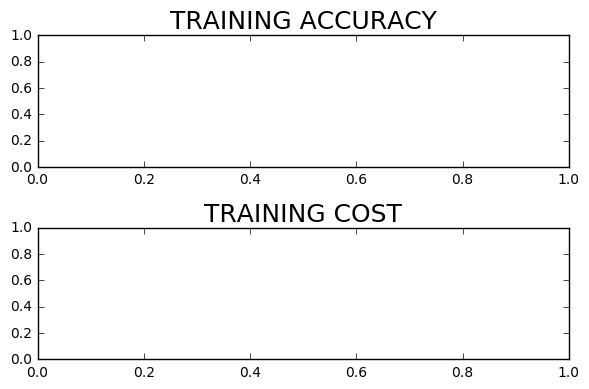

In [42]:
# GRAPH LIVE UPDATING
epoch_values = []
accuracy_values = []
cost_values = []
# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("211")
ax1.set_title("TRAINING ACCURACY", fontsize=18)
ax2 = plt.subplot("212")
ax2.set_title("TRAINING COST", fontsize=18)
plt.tight_layout()

# RUN THE GRAPH

In [43]:
# Create a tensorflow session
sess = tf.Session()
# Initialize all tensorflow variables
sess.run(init_OP)

In [44]:
# Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP, 1), tf.argmax(yGold, 1))

In [45]:
# False is 0 and True is 1, what was our average?
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))

In [46]:
# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)

In [47]:
# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)

In [48]:
# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)

In [49]:
# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))

In [50]:
# Merge all summaries
all_summary_OPS = tf.summary.merge_all()

In [51]:
# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

In [52]:
# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost%g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            summary_results, train_accuracy, newCost = sess.run(
                [all_summary_OPS, accuracy_OP, cost_OP],
                feed_dict = {X: trainX, yGold: trainY}
            )
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Write summary stats to writer
            writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost
            
            # generate print statements
            print("step %d, training accuracy %g"%(i, train_accuracy))
            print("step %d, cost %g"%(i, newCost))
            print("step %d, change in cost%g"%(i, diff))
            
            # Plot progress to our two subplots
            accuracyLine, = ax1.plot(epoch_values, accuracy_values)
            costLine, = ax2.plot(epoch_values, cost_values)
            fig.canvas.draw()
            time.sleep(1)

# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, feed_dict={X: testX, yGold: testY})))

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'Placeholder', defined at:
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-e036e9425593>", line 3, in <module>
    X = tf.placeholder(tf.float32, [None, numFeatures])
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1587, in placeholder
    name=name)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2043, in _placeholder
    name=name)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node 

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'Placeholder', defined at:
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-e036e9425593>", line 3, in <module>
    X = tf.placeholder(tf.float32, [None, numFeatures])
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1587, in placeholder
    name=name)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2043, in _placeholder
    name=name)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/Seth/anaconda/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


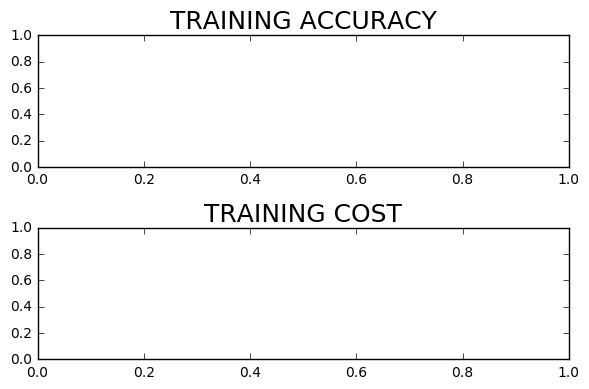

In [67]:
# GRAPH LIVE UPDATING
epoch_values = []
accuracy_values = []
cost_values = []
# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("211")
ax1.set_title("TRAINING ACCURACY", fontsize=18)
ax2 = plt.subplot("212")
ax2.set_title("TRAINING COST", fontsize=18)
plt.tight_layout()

# RUN THE GRAPH

# Create a tensorflow session
sess = tf.Session()
# Initialize all tensorflow variables
sess.run(init_OP)

# Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP, 1), tf.argmax(yGold, 1))
# False is 0 and True is 1, what was our average?
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
# Summary op for regression output
activation_summary_OP = tf.histogram_summary("output", activation_OP)
# Summary op for accuracy
accuracy_summary_OP = tf.scalar_summary("accuracy", accuracy_OP)
# Summary op for cost
cost_summary_OP = tf.scalar_summary("cost", cost_OP)
# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.histogram_summary("weights", weights.eval(session=sess))
biasSummary = tf.histogram_summary("biases", bias.eval(session=sess))
# Merge all summaries
all_summary_OPS = tf.merge_all_summaries()
# Summary writer
writer = tf.train.SummaryWriter("summary_logs", sess.graph)

# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost%g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            summary_results, train_accuracy, newCost = sess.run(
                [all_summary_OPS, accuracy_OP, cost_OP],
                feed_dict = {X: trainX, yGold: trainY}
            )
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Write summary stats to writer
            writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost
            
            # generate print statements
            print("step %d, training accuracy %g"%(i, train_accuracy))
            print("step %d, cost %g"%(i, newCost))
            print("step %d, change in cost%g"%(i, diff))
            
            # Plot progress to our two subplots
            accuracyLine, = ax1.plot(epoch_values, accuracy_values)
            costLine, = ax2.plot(epoch_values, cost_values)
            fig.canvas.draw()
            time.sleep(1)

# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, feed_dict={X: testX, yGold: testY})))

Save the Trained Variables

In [ ]:
# Create Saver
# saver = tf.train.Saver()
# Save variables to .ckpt file
# saver.save(sess, "trained_variables.ckpt")

# Close tensorflow session
sess.close()